In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

##### PATHS- set for multiple computers, see bottom to SET PATH

In [2]:
#ASO lidar - netCDFs & integers in [mm]
ars_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent_data_downsize/nc/20*/*int.nc'
# mac_path = ''
bsu_path = '/Users/meganmason491/Documents/research/sierra/data/mm/20*/*int.nc'
sonic_path = '/home/meganmason/Research/Sierra/data/mm/20*/*int.nc'
geohack_path = '/srv/shared/deep_stac/data/snowdepth/netcdf/20*/*int.nc'

#DEM & Mask for Tuolumne
ars_topo_path = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/basin_setup/topo.nc'
# mac_topo_path =
bsu_topo_path = '/Users/meganmason491/Documents/research/sierra/data/topo.nc'
sonic_topo_path = '/home/meganmason/Research/Sierra/data/topo.nc'
geohack_topo_path = '/srv/shared/deep_stac/data/topo.nc'


# ~~ SET PATH HERE ~~ #
path = ars_path
topo_path = ars_topo_path

##### FILEPATH LIST AND DATE PARSING

In [3]:
#filepath list, lidar
flist = sorted(glob.glob(path))
print('# of lidar files as input:', len(flist))

# Parse dates, store as pandas datetime type in list
fparse = [d.split('/')[-1] for d in flist] #splits fname on '/' saves last
fparse = [d.split('_')[0] for d in fparse] #splits fname on '_' saves first

# flight dates, parsed from filename
dates = pd.to_datetime(fparse) #pandas datetime variable, lidar dates
print('dates, file type is:', type(dates))

# of lidar files as input: 51
dates, file type is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


#### OPTION: run a smaller chunk, peak, etc.

In [4]:
'''first 2 files'''
# flist = flist[:2] #first 6 are just 2013
# dates = dates[:2]

'''peak snow depth dates....(?)'''
flist = list(flist[i] for i in (0,7,22,28,41,49))
dates = list(dates[i] for i in (0,7,22,28,41,49))

print('# of lidar files as input:', len(flist))
print('# of flight dates', len(dates))

# of lidar files as input: 6
# of flight dates 6


##### OPEN DATASET AND BUILD XARRAY

In [5]:
#load xarray, via multiple files
ds=xr.open_mfdataset(flist, concat_dim='time', combine='nested', chunks={'x':1000, 'y':1000}, parallel=True).rename({'Band1':'snow'})
ds.close()

ds = ds.drop('transverse_mercator') #remove
ds = ds.astype(np.int16, copy=False) #cast as int16 (32,767)
ds['time'] = (['time'], dates) #add 'time' coordinate, default populates with dimension called 'time'
# ds['snow'].values = ds.snow[::-1] # flip along y-axis (maybe do that as function, call: preprocess= <func_name> in open_mfds())
ds

<xarray.Dataset>
Dimensions:  (time: 6, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
Data variables:
    snow     (time, y, x) int16 dask.array<shape=(6, 17002, 17569), chunksize=(1, 1000, 1000)>

In [6]:
# open topo.nc
topo = xr.open_dataset(topo_path, drop_variables=['veg_tau','veg_k','veg_type','projection'], chunks={'x':1000, 'y':1000})
topo.close()

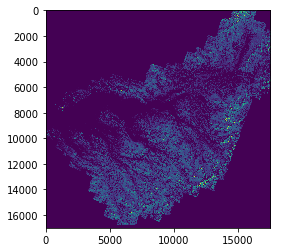

In [7]:
plt.figure()
plt.imshow(ds.isel(time=1).snow)
plt.show()